# 1. Module Import

In [1]:
import os
import numpy as np
import random

import matplotlib.pylab as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

import seaborn as sns

import torch
import torch.nn as nn  
from torch.utils import data

import torchvision
from torchvision import transforms


In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else: DEVICE = torch.device('cpu')
    
print('Using PyTorchversion:', torch.__version__, 'Device:', DEVICE)
print(f'Number of cuda available: {torch.cuda.device_count()}')

Using PyTorchversion: 1.8.0.dev20201207+cu101 Device: cuda
Number of cuda available: 3


In [4]:
!python --version

Python 3.6.9


In [5]:
os.getcwd()

'/home/ViT_SAM'

In [6]:
DATA_DIR = './Data/'

In [7]:
IMG_SIZE = 224

CLASS_NUM = 2

EPOCHS = 50
LR = 0.001
BATCH_SIZE = 32
TRAIN_PATIENCE = 5

# 4. Load Image

In [8]:
resized_normal_arr = np.load(f'./Data/{IMG_SIZE}_normal_arr.npy')
resized_opacity_arr = np.load(f'./Data/{IMG_SIZE}_opacity_arr.npy')

resized_normal_arr.shape, resized_opacity_arr.shape

((8851, 224, 224, 3), (6012, 224, 224, 3))

# 5. Data Preprocessing

In [9]:
# X_data = resized_normal_arr + resized_opacity_arr
X_data = np.concatenate((resized_normal_arr, resized_opacity_arr))

y_data = []

for i in range(len(resized_normal_arr)):
    y_data.append(0)
    
for i in range(len(resized_opacity_arr)):
    y_data.append(1)

In [10]:
X_data = np.array(X_data)
y_data = np.array(y_data)

X_data.shape, y_data.shape

((14863, 224, 224, 3), (14863,))

# 6. Balanced Train/Val/Test Split 8:1:1

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.1, random_state = 71, stratify = y_data)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=1/9, random_state = 71, stratify = y_train)

In [12]:
len(X_train), len(y_train),\
len(X_val), len(y_val),\
len(X_test), len(y_test)

(11889, 11889, 1487, 1487, 1487, 1487)

In [13]:
np.array(np.unique(y_train, return_counts=True)).T[0][1]/np.array(np.unique(y_train, return_counts=True)).T[1][1],\
np.array(np.unique(y_val, return_counts=True)).T[0][1]/np.array(np.unique(y_val, return_counts=True)).T[1][1],\
np.array(np.unique(y_test, return_counts=True)).T[0][1]/np.array(np.unique(y_test, return_counts=True)).T[1][1]

(1.4722395508421708, 1.4700996677740863, 1.4742096505823628)

# 7. Data Loader

In [14]:
class Dataset(data.Dataset):
    
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
    
    def __getitem__(self, index):
        image = self.images[index]
        label = int(self.labels[index])
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label
    
    def __len__(self):
        return len(self.images)

In [15]:
train_dataset = Dataset(X_train, y_train, transform = transforms.ToTensor())
val_dataset = Dataset(X_val, y_val, transform = transforms.ToTensor())
test_dataset = Dataset(X_test, y_test, transform = transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = True)   
val_loader = torch.utils.data.DataLoader(dataset = val_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = False)
test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                           batch_size = BATCH_SIZE,
                                          shuffle = False)

# 8. Check Data (SKIP)

In [20]:
print(len(train_loader))

for (X_train, y_train) in train_loader:
    print('X_train:', X_train.size(), 'type:', X_train.type())
    print('y_train:', y_train.size(), 'type:', y_train.type())
    break

372
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [21]:
print(len(val_loader))

for (X_val, y_val) in val_loader:
    print('X_train:', X_val.size(), 'type:', X_val.type())
    print('y_train:', y_val.size(), 'type:', y_val.type())
    break

47
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


In [22]:
print(len(test_loader))

for (X_test, y_test) in test_loader:
    print('X_train:', X_test.size(), 'type:', X_test.type())
    print('y_train:', y_test.size(), 'type:', y_test.type())
    break

47
X_train: torch.Size([32, 3, 224, 224]) type: torch.FloatTensor
y_train: torch.Size([32]) type: torch.LongTensor


# 9. Load Architectures  (SKIP)

In [46]:
# densenet = torchvision.models.densenet121(pretrained=False)
resnet = torchvision.models.resnet50(pretrained=False)

num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,CLASS_NUM)
resnet.fc = nn.Sequential(resnet.fc, nn.Softmax(),)

# resnet= nn.DataParallel(resnet)
model = resnet.to(DEVICE)

resnet.fc

Sequential(
  (0): Linear(in_features=2048, out_features=2, bias=True)
  (1): Softmax(dim=None)
)

In [47]:
vit = torchvision.models.vit_b_16()

num_ftrs = vit.heads.head.in_features
vit.heads.head = nn.Linear(num_ftrs,CLASS_NUM)
vit.heads = nn.Sequential(vit.heads.head, nn.Softmax(),)

model = vit.to(DEVICE)

vit.heads

Sequential(
  (0): Linear(in_features=768, out_features=2, bias=True)
  (1): Softmax(dim=None)
)

# 10. Model Setting  (SKIP)

In [48]:
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
criterion = nn.CrossEntropyLoss()

## SAM

In [ ]:
from sampytorch.sam import SAMSGD     # !git clone https://github.com/moskomule/sam.pytorch.git

optimizer = SAMSGD(model.parameters(),lr=LR, rho=0.05) # -- for SGD
criterion = nn.CrossEntropyLoss()

# 12. Define Training Function

In [16]:
# this function is used during training process, to calculation the loss and accuracy

class AverageMeter(object):
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [17]:
def train(sam, model, train_loader, Epoch, optimizer, log_interval):
    model.train()                                                 # assign train mode to the model
    
    train_loss = AverageMeter()
    train_acc = AverageMeter()
    
    if sam == False:
      for batch_idx, (image, label) in enumerate(train_loader):
          image = image.to(DEVICE)
          label = label.to(DEVICE)
          optimizer.zero_grad()                                     # 과거에 이용한 Mini-Batch내에 있는 이미지 데이터와 레이블 데이터를 바탕으로 계산된 Loss의 Gradient값이 optimizer에 할당되어 있으므로 optimizer의 Gradient 초기화
          output = model(image)

          with torch.set_grad_enabled(True):
            loss = criterion(output, label)
            loss.backward()                                           # Back propagation으로 계산된 Gradient 값을 각 parameter에 할당
            optimizer.step()                                          # parameter update
            prediction = output.max(1, keepdim = True)[1]             # predicted labels in tensor
            
            train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            train_loss.update(loss.item())
            
            if batch_idx % log_interval == 0:                         # print log
                print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))
    
    elif sam == True:
      for batch_idx, (image, label) in enumerate(train_loader):
          image = image.to(DEVICE)
          label = label.to(DEVICE)

          def closure():
              optimizer.zero_grad()
              output = model(image)
              loss = criterion(output, label)
              loss.backward()
              return loss

          loss = optimizer.step(closure)                      # parameter update
          prediction = model(image).max(1, keepdim = True)[1]             # predicted labels in tensor
            
          train_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
          train_loss.update(loss.item())
          
          if batch_idx % log_interval == 0:                         # print log
              print("Train Epoch: {} [{}/{}({:.0f}%)]\tTrain Loss: {:.6f}".format(Epoch, batch_idx * len(image), len(train_loader.dataset), 100. * batch_idx / len(train_loader), loss.item()))  
    
    return train_loss.avg, train_acc.avg

# 13. Define Model Evaluating Function

In [18]:
def evaluate(model, test_loader):
    model.eval()
    
    val_loss = AverageMeter()
    val_acc = AverageMeter()
    
    with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            output = model(image)
            loss = criterion(output, label)
            prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
    
            val_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
            val_loss.update(loss.item())
    
    return val_loss.avg, val_acc.avg   

# 14. Define Model Training Function

In [19]:
def startTrain(model, optimizer, opt):
    best_val_acc = 0
    best_val_loss = 100
    epoch = 0
    total_loss_train, total_acc_train = [],[]
    total_loss_val, total_acc_val = [],[]

    for Epoch in range(1, EPOCHS+1):
        train_loss, train_acc = train(opt, model, train_loader, Epoch, optimizer, log_interval = 200)
        total_acc_train.append(train_acc)
        total_loss_train.append(train_loss)

        val_loss, val_acc = evaluate(model, val_loader)
        total_acc_val.append(val_acc)
        total_loss_val.append(val_loss)
        print(Epoch)
        print("\n[EPOCH: {}], \tVal Loss: {:.4f}, \tVal Accuracy: {:.2f} %\n".format(Epoch, val_loss, val_acc))
        
        # monitoring test accuracy
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            epoch = Epoch
            print('*****************************************************')
            print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
            print('*****************************************************')
        elif Epoch > epoch + TRAIN_PATIENCE:
            break
        
        # # monitoring val loss

        # if val_loss < best_val_loss:
        #     best_val_loss = val_loss
        #     epoch = Epoch
        #     print('*****************************************************')
        #     print('best record: [epoch %d], [val loss %.5f], [val acc %.5f]' % (Epoch, val_loss, val_acc))
        #     print('*****************************************************')
        # elif Epoch > epoch + TRAIN_PATIENCE:
        #     break

    return epoch, total_loss_train, total_acc_train, total_loss_val, total_acc_val, best_val_acc

# RUN

### Model Analysis / Selection

In [38]:
# or https://github.com/rwightman/pytorch-image-models/blob/main/results/results-imagenet.csv
def numParam(model):
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [105]:
numParam(resnet), numParam(vit) # resnet10t, vit_tiny_patch16_224

(4923514, 5524802)

## RUN

In [20]:
EPOCHS = 50

In [40]:
!pip install timm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 549 kB 4.3 MB/s 
     |████████████████████████████████| 182 kB 89.1 MB/s 


In [22]:
!git clone https://github.com/moskomule/sam.pytorch.git

Cloning into 'sam.pytorch'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 30 (delta 13), reused 15 (delta 5), pack-reused 0
Unpacking objects: 100% (30/30), done.


In [27]:
from sampytorch.sam import SAMSGD 
import timm

In [ ]:
from sampytorch.sam import SAMSGD 
import timm

REPEAT = 5
models = ['resnet10t', 'vit_tiny_patch16_224']
optims = ['base', 'sam'] #SGD
lrs = [0.00001, 0.0001, 0.001]

# resnet = timm.create_model('resnet50', pretrained=False) # Param 23512130 / 25.56
# resnet = timm.create_model('resnet18', pretrained=False) # Param 11177538 / 11.69
resnet = timm.create_model('resnet10t', pretrained=False) # Param 4923514 / 5.44
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,CLASS_NUM)
resnet.fc = nn.Sequential(resnet.fc, nn.Softmax(),)

# vit = timm.create_model('vit_small_patch32_224', pretrained=False) # Param 22494722 / 22.88
vit = timm.create_model('vit_tiny_patch16_224', pretrained=False) # Param 5524802 / 5.72
num_ftrs = vit.head.in_features
vit.head = nn.Linear(num_ftrs,CLASS_NUM)
vit.head = nn.Sequential(vit.head, nn.Softmax(),)

for LR in lrs:
  for _ in range(REPEAT):
    for arch in models:
      print(f'Architecture: {arch}')

      if arch[:6] == 'resnet':
        model = resnet.to(DEVICE)

      elif arch[:3] == 'vit':
        model = vit.to(DEVICE)

      else: print('엥 이게 뭐람')

      criterion = nn.CrossEntropyLoss()

      for optim in optims:
        print(f'Optimizer: {optim}')
        try:
          os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/saved-models/{arch}/{optim}/{LR}/')
        except FileExistsError : pass

        if optim == 'base':
          opt = False
          optimizer = torch.optim.SGD(model.parameters(), lr = LR, momentum=0.05)

        elif optim == 'sam':
          opt = True
          optimizer = SAMSGD(model.parameters(),lr=LR, rho=0.05) # -- for SGD
        
        epoch, total_loss_train, total_acc_train, total_loss_val, total_acc_val = startTrain(model, optimizer, opt)
        PATH = "./saved-models/{arch}/{optim}/{LR}/model-epoch{epoch:02d}-loss_val{loss_val:.2f}-acc_val{acc_val:.2f}.pt".format(arch = arch, optim = optim, LR = LR, epoch = epoch, loss_val = total_loss_val[epoch-1] , acc_val = total_acc_val[epoch-1])

        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(), # trained parameters
                    'optimizer_state_dict': optimizer.state_dict(), # this contains buffers and parameters that are updated as the model trains
                    'accuracy':best_val_acc, 
                    'loss': best_val_loss,
                    'total_loss_train':total_loss_train,
                    'total_acc_train':total_acc_train,
                    'total_loss_val':total_loss_val,
                    'total_acc_val':total_acc_val,
                    }, PATH)
        
        print(f'Saved {arch} model with {optim} optimizer to {PATH}')

Architecture: resnet10t
Optimizer: base
Train Epoch: 1 [0/11889(0%)]	Train Loss: 0.654276
Train Epoch: 1 [6400/11889(54%)]	Train Loss: 0.540590
1

[EPOCH: 1], 	Val Loss: 0.5550, 	Val Accuracy: 0.77 %

*****************************************************
best record: [epoch 1], [val loss 0.55498], [val acc 0.77061]
*****************************************************
Train Epoch: 2 [0/11889(0%)]	Train Loss: 0.559039
Train Epoch: 2 [6400/11889(54%)]	Train Loss: 0.575963
2

[EPOCH: 2], 	Val Loss: 0.5188, 	Val Accuracy: 0.79 %

*****************************************************
best record: [epoch 2], [val loss 0.51884], [val acc 0.79388]
*****************************************************
Train Epoch: 3 [0/11889(0%)]	Train Loss: 0.485211
Train Epoch: 3 [6400/11889(54%)]	Train Loss: 0.553062
3

[EPOCH: 3], 	Val Loss: 0.4966, 	Val Accuracy: 0.83 %

*****************************************************
best record: [epoch 3], [val loss 0.49661], [val acc 0.83178]
*********************

In [ ]:
from sampytorch.sam import SAMSGD 
import timm

REPEAT = 5
models = ['resnet50', 'vit_small_patch32_224']
optims = ['base', 'sam'] #SGD
lrs = [0.00001, 0.0001, 0.001]

resnet = timm.create_model('resnet50', pretrained=False) # Param 23512130 / 25.56
# resnet = timm.create_model('resnet18', pretrained=False) # Param 11177538 / 11.69
# resnet = timm.create_model('resnet10t', pretrained=False) # Param 4923514 / 5.44
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,CLASS_NUM)
resnet.fc = nn.Sequential(resnet.fc, nn.Softmax(),)

vit = timm.create_model('vit_small_patch32_224', pretrained=False) # Param 22494722 / 22.88
# vit = timm.create_model('vit_tiny_patch16_224', pretrained=False) # Param 5524802 / 5.72
num_ftrs = vit.head.in_features
vit.head = nn.Linear(num_ftrs,CLASS_NUM)
vit.head = nn.Sequential(vit.head, nn.Softmax(),)


for LR in lrs:
  for _ in range(REPEAT):
    for arch in models:
      print(f'Architecture: {arch}')

      if arch[:6] == 'resnet':
        model = resnet.to(DEVICE)

      elif arch[:3] == 'vit':
        model = vit.to(DEVICE)

      else: print('엥 이게 뭐람')

      criterion = nn.CrossEntropyLoss()

      for optim in optims:
        print(f'Optimizer: {optim}')
        try:
          os.makedirs(f'/content/drive/MyDrive/Colab Notebooks/saved-models/{arch}/{optim}/{LR}/')
        except FileExistsError : pass

        if optim == 'base':
          opt = False
          optimizer = torch.optim.Adam(model.parameters(), lr = LR)

        elif optim == 'sam':
          opt = True
          optimizer = SAMSGD(model.parameters(),lr=LR, rho=0.05) # -- for SGD
        
        epoch, total_loss_train, total_acc_train, total_loss_val, total_acc_val = startTrain(model, optimizer, opt)
        PATH = "./saved-models/{arch}/{optim}/{LR}/model-epoch{epoch:02d}-loss_val{loss_val:.2f}-acc_val{acc_val:.2f}.pt".format(arch = arch, optim = optim, LR = LR, epoch = epoch, loss_val = total_loss_val[epoch-1] , acc_val = total_acc_val[epoch-1])

        torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(), # trained parameters
                    'optimizer_state_dict': optimizer.state_dict(), # this contains buffers and parameters that are updated as the model trains
                    'accuracy':best_val_acc, 
                    'loss': best_val_loss,
                    'total_loss_train':total_loss_train,
                    'total_acc_train':total_acc_train,
                    'total_loss_val':total_loss_val,
                    'total_acc_val':total_acc_val,
                    }, PATH)
        
        print(f'Saved {arch} model with {optim} optimizer to {PATH}')

## LOAD MODEL

In [42]:
# resnet = timm.create_model('resnet50', pretrained=False) # Param 23512130 / 25.56
# resnet = timm.create_model('resnet18', pretrained=False) # Param 11177538 / 11.69
resnet = timm.create_model('resnet10t', pretrained=False) # Param 4923514 / 5.44
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs,CLASS_NUM)
resnet.fc = nn.Sequential(resnet.fc, nn.Softmax(),)

# vit = timm.create_model('vit_small_patch32_224', pretrained=False) # Param 22494722 / 22.88
vit = timm.create_model('vit_tiny_patch16_224', pretrained=False) # Param 5524802 / 5.72
num_ftrs = vit.head.in_features
vit.head = nn.Linear(num_ftrs,CLASS_NUM)
vit.head = nn.Sequential(vit.head, nn.Softmax(),)

In [43]:
path = '/content/drive/MyDrive/Colab Notebooks/saved-models/resnet10t/base/model-epoch16-loss_val0.39-acc_val0.91.pt'
model = resnet.to(DEVICE)

#base
optimizer = torch.optim.Adam(model.parameters(), lr = LR)
# #sam
# optimizer = SAMSGD(model.parameters(),lr=LR, rho=0.05) # -- for SGD


In [ ]:
checkpoint = torch.load(path)
model.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
accuracy = checkpoint['accuracy']
# loss = checkpoint['loss']
total_loss_train = checkpoint['total_loss_train']
total_acc_train = checkpoint['total_acc_train']
total_loss_val = checkpoint['total_loss_val']
total_acc_val = checkpoint['total_acc_val']

model.eval()

## EVALUATE

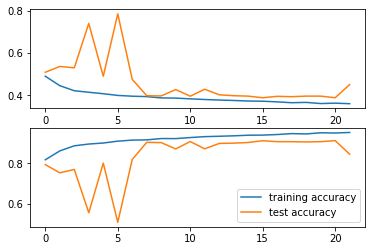

0.3880617168355495 0.9115691489361702


In [45]:
fig = plt.figure(num = 2)
fig1 = fig.add_subplot(2,1,1)
fig2 = fig.add_subplot(2,1,2)
fig1.plot(total_loss_train, label = 'training loss')
fig1.plot(total_loss_val, label = 'test loss')
fig2.plot(total_acc_train, label = 'training accuracy')
fig2.plot(total_acc_val, label = 'test accuracy')
plt.legend()
plt.show()

print(min(total_loss_val), max(total_acc_val))

In [49]:
true_labels = []
predicted_labels = []
predicted_values = []

model.eval()
    
test_loss = AverageMeter()
test_acc = AverageMeter()

with torch.no_grad():                                                     # 모델을 평가하는 단계에서는 Gradient를 통해 parameter값이 update되는 현상을 방지하기 위해 'torch.no_grad()' 메서드를 이용해 Gradient의 흐름을 억제
    for image, label in test_loader:
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        output = model(image)
        loss = criterion(output, label)
        prediction = output.max(1, keepdim = True)[1]                     # output값 (prediction probability)가 가장 높은 index(class)로 예측
        
        true_labels.append(label)
        predicted_labels.append(prediction)
        predicted_values.append(output)
        
        test_acc.update(prediction.eq(label.view_as(prediction)).sum().item()/BATCH_SIZE)
        test_loss.update(loss.item())
        
test_loss.avg, test_acc.avg

NameError: ignored

0.9189030321923957


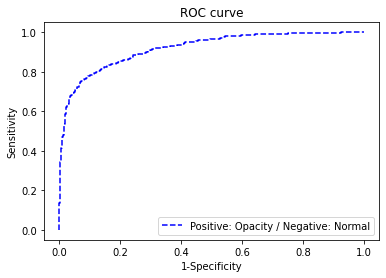

In [115]:
## ROC Curve / AUC ##

# tensor to array form
true_test_lst = []
predicted_test_lst = []
predicted_value_lst = []

for i in range(len(test_loader)):
    t_labels = true_labels[i].cpu().numpy()
    true_test_lst += list(t_labels)
    
    p_labels = predicted_labels[i].cpu().numpy()[:,0]
    predicted_test_lst += list(p_labels)
    
    p_values = predicted_values[i].cpu().numpy()
    predicted_value_lst += list(p_values)
    
true_test_arr = np.array(true_test_lst)
predicted_test_arr = np.array(predicted_test_lst)
predicted_value_arr = np.array([list(arr) for arr in predicted_value_lst])
    
true_test_arr[:20], predicted_test_arr[:20], predicted_value_arr[:20]

# roc curve for classes

fpr = {}
tpr = {}
thresh ={}

n_class = 2

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(true_test_arr == i, predicted_value_arr[:, i])
    
# plotting
plt.plot(fpr[1], tpr[1], linestyle='--',color='blue', label='Positive: Opacity / Negative: Normal') # Sensitivity: 비정상 중에 비정상으로 predict된 비율 / Specificity: 정상 중에 정상으로 predict된 비율
plt.title('ROC curve')
plt.xlabel('1-Specificity')
plt.ylabel('Sensitivity')
plt.legend(loc='best') 

print(auc(fpr[1], tpr[1]))
